In [109]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [110]:
sampled_data = pd.read_csv('./sampled_data_reduced_50.csv')

In [111]:
feature = '01_DL_FLCOR_CH0E_REV1_ > 214_SYS2_COMP1_DISCH_TEMP'
sampled_data[feature]
print("NaN values per column before preprocessing:", sampled_data.isna().sum())


NaN values per column before preprocessing: TIME                                                   0
01_DL_FLCOR_CH0E_REV1_ > 001_ECHW_TMP                  0
01_DL_FLCOR_CH0E_REV1_ > 002_LCHW_TEMP                 0
01_DL_FLCOR_CH0E_REV1_ > 003_CHW_PMP1_ENA              0
01_DL_FLCOR_CH0E_REV1_ > 005_CHW_FLO                   0
01_DL_FLCOR_CH0E_REV1_ > 064_CHLR_ENA                  0
01_DL_FLCOR_CH0E_REV1_ > 067_CW_SP                     0
01_DL_FLCOR_CH0E_REV1_ > 072_MACHINE_CAP               0
01_DL_FLCOR_CH0E_REV1_ > 073_AMB_TMP_DB                0
01_DL_FLCOR_CH0E_REV1_ > 078_SYS1_SUC_PRESS            0
01_DL_FLCOR_CH0E_REV1_ > 079_SYS1_SUCT_TSAT            0
01_DL_FLCOR_CH0E_REV1_ > 080_SYS1_DISH_PRESS           0
01_DL_FLCOR_CH0E_REV1_ > 081_SYS1_SAT_DISCH_TEMP       0
01_DL_FLCOR_CH0E_REV1_ > 084_SYS1_SYS_CAP              0
01_DL_FLCOR_CH0E_REV1_ > 085_SYS1_EEV_EVAP_STEPS       0
01_DL_FLCOR_CH0E_REV1_ > 087_SYS1_COND_FAN_OP          0
01_DL_FLCOR_CH0E_REV1_ > 090_SYS1_LIQ_LINE_T

In [112]:
feature = '01_DL_FLCOR_CH0E_REV1_ > 214_SYS2_COMP1_DISCH_TEMP'
sampled_data[feature] = pd.to_numeric(sampled_data[feature], errors='coerce')
sampled_data.ffill(inplace=True)  # forward fill to handle remaining NaNs

print("NaN values per column after preprocessing:", sampled_data.isna().sum())


NaN values per column after preprocessing: TIME                                                   0
01_DL_FLCOR_CH0E_REV1_ > 001_ECHW_TMP                  0
01_DL_FLCOR_CH0E_REV1_ > 002_LCHW_TEMP                 0
01_DL_FLCOR_CH0E_REV1_ > 003_CHW_PMP1_ENA              0
01_DL_FLCOR_CH0E_REV1_ > 005_CHW_FLO                   0
01_DL_FLCOR_CH0E_REV1_ > 064_CHLR_ENA                  0
01_DL_FLCOR_CH0E_REV1_ > 067_CW_SP                     0
01_DL_FLCOR_CH0E_REV1_ > 072_MACHINE_CAP               0
01_DL_FLCOR_CH0E_REV1_ > 073_AMB_TMP_DB                0
01_DL_FLCOR_CH0E_REV1_ > 078_SYS1_SUC_PRESS            0
01_DL_FLCOR_CH0E_REV1_ > 079_SYS1_SUCT_TSAT            0
01_DL_FLCOR_CH0E_REV1_ > 080_SYS1_DISH_PRESS           0
01_DL_FLCOR_CH0E_REV1_ > 081_SYS1_SAT_DISCH_TEMP       0
01_DL_FLCOR_CH0E_REV1_ > 084_SYS1_SYS_CAP              0
01_DL_FLCOR_CH0E_REV1_ > 085_SYS1_EEV_EVAP_STEPS       0
01_DL_FLCOR_CH0E_REV1_ > 087_SYS1_COND_FAN_OP          0
01_DL_FLCOR_CH0E_REV1_ > 090_SYS1_LIQ_LINE_TM

In [113]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(sampled_data[[feature]])


In [114]:
# Create dataset function
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [115]:
look_back = 10
X, Y = create_dataset(dataset_scaled, look_back)

# Check the shape of X and Y after dataset creation
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (310135, 10)
Shape of Y: (310135,)


In [116]:
# Reshape input
X = np.reshape(X, (X.shape[0], look_back, 1))
# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [117]:
# Create and fit the LSTM network
model = Sequential()
model.add(Input(shape=(look_back, 1)))
model.add(LSTM(25, return_sequences=True))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
7754/7754 - 77s - loss: 0.0552 - 77s/epoch - 10ms/step
Epoch 2/10
7754/7754 - 73s - loss: 0.0545 - 73s/epoch - 9ms/step
Epoch 3/10
7754/7754 - 71s - loss: 0.0544 - 71s/epoch - 9ms/step
Epoch 4/10
7754/7754 - 72s - loss: 0.0544 - 72s/epoch - 9ms/step
Epoch 5/10
7754/7754 - 72s - loss: 0.0544 - 72s/epoch - 9ms/step
Epoch 6/10
7754/7754 - 72s - loss: 0.0544 - 72s/epoch - 9ms/step
Epoch 7/10
7754/7754 - 71s - loss: 0.0544 - 71s/epoch - 9ms/step
Epoch 8/10
7754/7754 - 71s - loss: 0.0544 - 71s/epoch - 9ms/step
Epoch 9/10
7754/7754 - 72s - loss: 0.0544 - 72s/epoch - 9ms/step
Epoch 10/10
7754/7754 - 70s - loss: 0.0544 - 70s/epoch - 9ms/step


In [118]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1939/1939 [==============================] - 7s 4ms/step


In [119]:
# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [120]:
# Inverse transform actual values
Y_train = scaler.inverse_transform([Y_train]).flatten()
Y_test = scaler.inverse_transform([Y_test]).flatten()

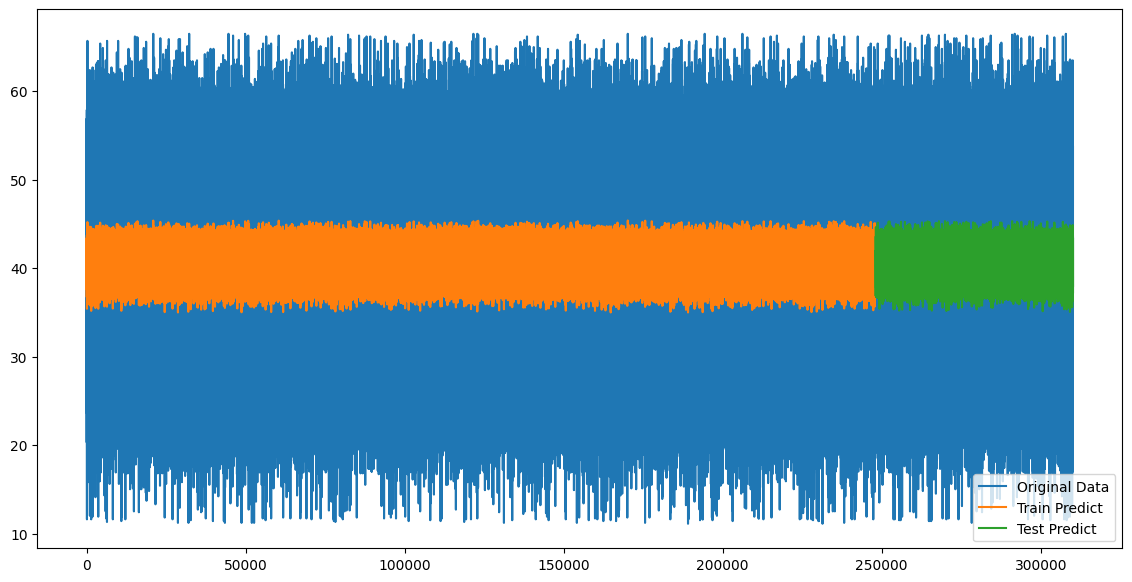

In [121]:
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(dataset_scaled), label='Original Data')
plt.plot(np.arange(look_back, len(train_predict) + look_back), train_predict, label='Train Predict')
plt.plot(np.arange(len(train_predict) + (look_back * 2), len(train_predict) + (look_back * 2) + len(test_predict)), test_predict, label='Test Predict')
plt.legend()
plt.savefig('Train-test-predict.png')
plt.show()

In [122]:
# Forecast next 10 days
last_look_back = dataset_scaled[-look_back:]
future_predictions = []

In [123]:
for i in range(10):
    next_pred = model.predict(last_look_back.reshape(1, look_back, 1))
    future_predictions.append(next_pred[0, 0])
    last_look_back = np.append(last_look_back[1:], next_pred)
    last_look_back = last_look_back.reshape(look_back, 1)  # Ensure correct shape

    # Debugging statements
    print(f"Step {i+1}")
    print(f"Next prediction: {next_pred[0, 0]}")
    print(f"Updated last_look_back: {last_look_back}")

1/1 [==============================] - 0s 20ms/step
Step 1
Next prediction: 0.5793136358261108
Updated last_look_back: [[0.79602888]
 [0.79602888]
 [0.74187726]
 [0.22202166]
 [0.27797834]
 [0.2166065 ]
 [0.29422383]
 [0.79422383]
 [0.76895307]
 [0.57931364]]
1/1 [==============================] - 0s 21ms/step
Step 2
Next prediction: 0.543779730796814
Updated last_look_back: [[0.79602888]
 [0.74187726]
 [0.22202166]
 [0.27797834]
 [0.2166065 ]
 [0.29422383]
 [0.79422383]
 [0.76895307]
 [0.57931364]
 [0.54377973]]
1/1 [==============================] - 0s 19ms/step
Step 3
Next prediction: 0.5350573062896729
Updated last_look_back: [[0.74187726]
 [0.22202166]
 [0.27797834]
 [0.2166065 ]
 [0.29422383]
 [0.79422383]
 [0.76895307]
 [0.57931364]
 [0.54377973]
 [0.53505731]]
1/1 [==============================] - 0s 27ms/step
Step 4
Next prediction: 0.5327678918838501
Updated last_look_back: [[0.22202166]
 [0.27797834]
 [0.2166065 ]
 [0.29422383]
 [0.79422383]
 [0.76895307]
 [0.57931364]
 [0.

In [124]:
# Inverse transform future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print("Future 10 days predictions:", future_predictions)

Future 10 days predictions: [[43.193977]
 [41.2254  ]
 [40.742176]
 [40.61534 ]
 [40.60855 ]
 [40.627785]
 [40.644142]
 [40.654736]
 [40.659912]
 [40.6591  ]]
